In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore") 

## Load Data

In [2]:
import pandas as pd
from scipy.spatial import distance
#https://www.google.com/covid19/mobility/
url = 'https://drive.google.com/file/d/18gyHbx6rfogq3yQ-GR9COjcGgyYlCnBZ/view?usp=sharing'
url2020 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
import pandas as pd
url = 'https://drive.google.com/file/d/1Eg8Lffm49bc-bGFkv_4ddrQw8U8WE6P4/view?usp=sharing'
url2021 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [3]:
df20 = pd.read_csv(url2020)
df21 = pd.read_csv(url2021)

**retail_and_recreation_percent_change_from_baseline**

Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.

**grocery_and_pharmacy_percent_change_from_baseline**

Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.

**parks_percent_change_from_baseline**

Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.

**transit_stations_percent_change_from_baseline**

Mobility trends for places like public transport hubs such as subway, bus, and train stations.

**workplaces_percent_change_from_baseline**

Mobility trends for places of work.


In [399]:
len(df20.place_id.unique())

584

In [4]:
df20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167657 entries, 0 to 167656
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 167657 non-null  object 
 1   country_region                                      167657 non-null  object 
 2   sub_region_1                                        167336 non-null  object 
 3   sub_region_2                                        141692 non-null  object 
 4   metro_area                                          0 non-null       float64
 5   iso_3166_2_code                                     25644 non-null   object 
 6   census_fips_code                                    0 non-null       float64
 7   place_id                                            167657 non-null  object 
 8   date                                                167657 non-n

In [5]:
df21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158430 entries, 0 to 158429
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 158430 non-null  object 
 1   country_region                                      158430 non-null  object 
 2   sub_region_1                                        158152 non-null  object 
 3   sub_region_2                                        135654 non-null  object 
 4   metro_area                                          0 non-null       float64
 5   iso_3166_2_code                                     22498 non-null   object 
 6   census_fips_code                                    0 non-null       float64
 7   place_id                                            158430 non-null  object 
 8   date                                                158430 non-n

In [401]:
frames = [df20, df21]
g_mob=pd.concat(frames)
g_mob.index=range(0,len(g_mob))
g_mob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326087 entries, 0 to 326086
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 326087 non-null  object 
 1   country_region                                      326087 non-null  object 
 2   sub_region_1                                        325488 non-null  object 
 3   sub_region_2                                        277346 non-null  object 
 4   metro_area                                          0 non-null       float64
 5   iso_3166_2_code                                     48142 non-null   object 
 6   census_fips_code                                    0 non-null       float64
 7   place_id                                            326087 non-null  object 
 8   date                                                326087 non-n

In [410]:
g_mob.head()

,date,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
0,2020-02-15,2.0,3.0,-11.0,-4.0,7.0
1,2020-02-16,7.0,6.0,14.0,2.0,5.0
2,2020-02-17,6.0,5.0,10.0,5.0,8.0
3,2020-02-18,4.0,6.0,11.0,4.0,8.0
4,2020-02-19,0.0,3.0,6.0,0.0,9.0


In [402]:
g_mob=g_mob[["date",
             "retail_and_recreation_percent_change_from_baseline",
             "grocery_and_pharmacy_percent_change_from_baseline",
             "parks_percent_change_from_baseline",
             "transit_stations_percent_change_from_baseline",
             "workplaces_percent_change_from_baseline"]]
g_mob.rename(columns={
             "date":"date",
             "retail_and_recreation_percent_change_from_baseline":"restaurants_cafes" ,
             "grocery_and_pharmacy_percent_change_from_baseline":"grocery_pharmacies" ,
             "parks_percent_change_from_baseline":"parks" ,
             "transit_stations_percent_change_from_baseline":"subway_train" ,
             "workplaces_percent_change_from_baseline":"workplaces" 
}, 
             inplace=True);

In [403]:
g_mob.head(300)

,date,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
0,2020-02-15,2.0,3.0,-11.0,-4.0,7.0
1,2020-02-16,7.0,6.0,14.0,2.0,5.0
2,2020-02-17,6.0,5.0,10.0,5.0,8.0
3,2020-02-18,4.0,6.0,11.0,4.0,8.0
4,2020-02-19,0.0,3.0,6.0,0.0,9.0
...,...,...,...,...,...,...
295,2020-12-06,-88.0,-69.0,-77.0,-79.0,-57.0
296,2020-12-07,-37.0,11.0,-12.0,-25.0,-25.0
297,2020-12-08,-41.0,6.0,-19.0,-28.0,-25.0
298,2020-12-09,-44.0,5.0,-17.0,-30.0,-25.0


In [404]:
g_mob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326087 entries, 0 to 326086
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                326087 non-null  object 
 1   restaurants_cafes   193035 non-null  float64
 2   grocery_pharmacies  198593 non-null  float64
 3   parks               182285 non-null  float64
 4   subway_train        166532 non-null  float64
 5   workplaces          313542 non-null  float64
dtypes: float64(5), object(1)
memory usage: 14.9+ MB


#### Biraz inceledikten sonra bazı veri ön işleme adımlarını gerçekleştirmemiz gerektiği görüldü
- Bazı columnlarda fazla sayıda eksik değer var. Bu eksik değerleri doldurmalıyız.  
- __"Date"__ değişkeni ayırıp, gün, ay, hafta şeklinde 3 sütun daha eklemek bizim için faydalı olacak.
- Tarihlere göre mobility değişimini hakkında bir içgörü kazanmak adına verileri görselleştireceğiz. Bununla birlikte, bu görselleştirmeye "covid ölümleri" ni de dahil edersek faydalı lacak. O yüzden Covid- ölüm datasını bu dataya ekleyeceğiz. Şu anlık bunları yapıp devam edeceğiz. 


__Eksik gözlem analizi__  

In [670]:
#!pip install ycimpute
from ycimpute.imputer import knnimput
names=list(g_mob)
nparray_df=np.array(g_mob.iloc[:, 1:])
nparray_df.shape

(326087, 5)

In [406]:
features_to_fill=["restaurants_cafes","grocery_pharmacies","parks","subway_train","workplaces"]
filled_df_array=np.zeros(nparray_df.shape)
curr=0
row_size_of_g_mob=g_mob.shape[0]
for i in np.arange(10000, row_size_of_g_mob,10000):
    if(np.any(np.isnan(nparray_df[curr:i][:]))):
        filled_df_array[curr:i]=knnimput.KNN(k = 37).complete(nparray_df[curr:i][:]);
    curr=i

if(np.any(np.isnan(nparray_df[curr:][:]))):
    filled_df_array[curr:]=knnimput.KNN(k = 37).complete(nparray_df[curr:row_size_of_g_mob][:]);

Imputing row 1/10000 with 0 missing, elapsed time: 9.261
Imputing row 101/10000 with 0 missing, elapsed time: 9.262
Imputing row 201/10000 with 0 missing, elapsed time: 9.262
Imputing row 301/10000 with 0 missing, elapsed time: 9.262
Imputing row 401/10000 with 0 missing, elapsed time: 9.262
Imputing row 501/10000 with 0 missing, elapsed time: 9.263
Imputing row 601/10000 with 0 missing, elapsed time: 9.263
Imputing row 701/10000 with 0 missing, elapsed time: 9.263
Imputing row 801/10000 with 0 missing, elapsed time: 9.264
Imputing row 901/10000 with 0 missing, elapsed time: 9.265
Imputing row 1001/10000 with 0 missing, elapsed time: 9.266
Imputing row 1101/10000 with 0 missing, elapsed time: 9.267
Imputing row 1201/10000 with 0 missing, elapsed time: 9.269
Imputing row 1301/10000 with 1 missing, elapsed time: 9.271
Imputing row 1401/10000 with 1 missing, elapsed time: 9.278
Imputing row 1501/10000 with 2 missing, elapsed time: 9.283
Imputing row 1601/10000 with 4 missing, elapsed time

In [671]:
g_mob_filled=g_mob.copy()
print(g_mob_filled.isnull().values.any())
g_mob_filled.iloc[:][features_to_fill]=filled_df_array
print(g_mob_filled.isnull().values.any())
g_mob_filled=g_mob_filled.groupby(by="date").sum()

True
False


In [672]:
g_mob_filled.head(3)

,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
date,,,,,
2020-02-15,-257.890638,2711.831839,-727.307719,-5087.328405,1802.777176
2020-02-16,835.410295,3733.188398,4267.642291,-2165.300231,746.707173
2020-02-17,2037.248695,4134.698009,6486.155723,-2075.397992,4004.551213


In [673]:
covid_filled.head(3)

,daily_case,daily_patient,daily_death,daily_healed,date
0,0.0,0.0,0.0,0.0,2020-03-11
1,0.0,0.0,0.0,0.0,2020-03-12
2,0.0,0.0,0.0,0.0,2020-03-13


In [677]:
g_mob_filled.isnull().value_counts()

restaurants_cafes  grocery_pharmacies  parks  subway_train  workplaces
False              False               False  False         False         599
dtype: int64

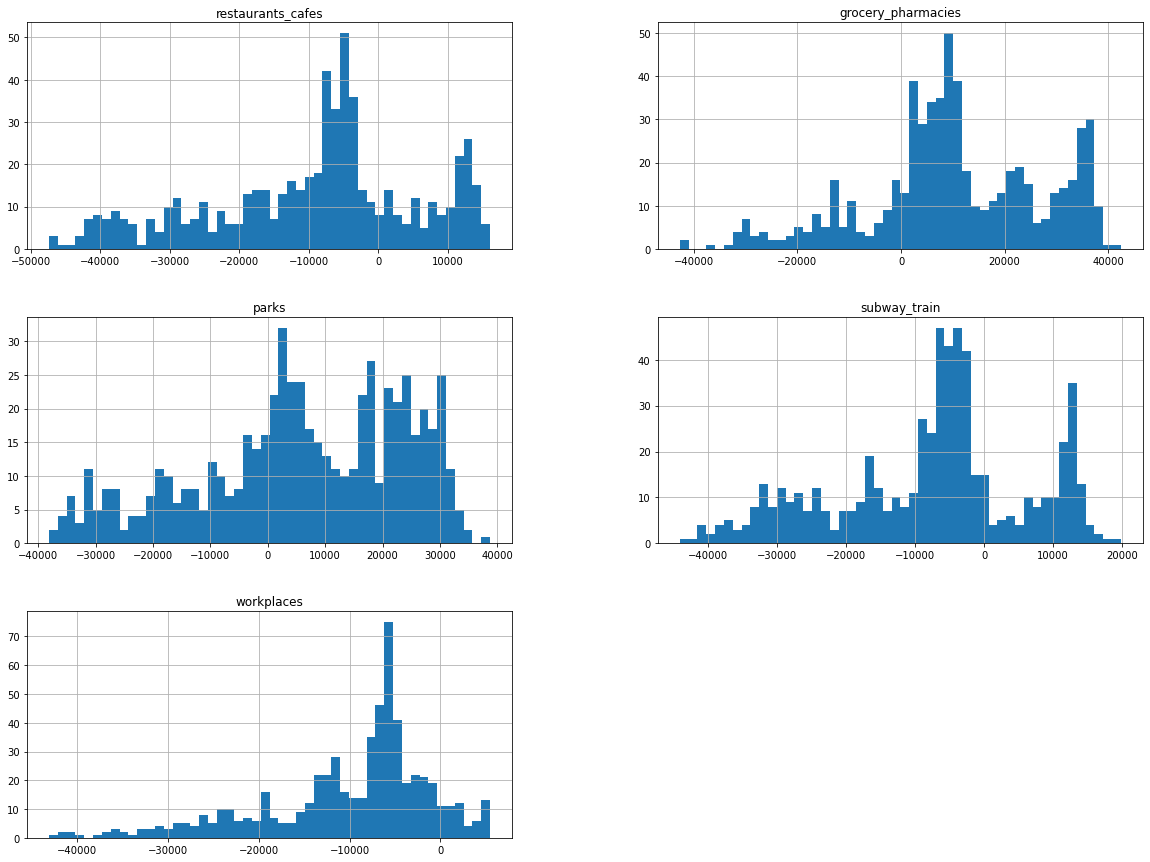

In [674]:
g_mob_filled.hist(bins=50, figsize=(20,15))
plt.show()

# T.C sağlık bakanlığı web sitesinden çekilen corona virüsü-vaka grafiğinin dataFrame'e eklenmesi:

In [724]:
import pandas as pd
covid_tr_data = pd.read_html('htmldeneme.html', encoding="utf-8")[0]

covid_tr_data=covid_tr_data[["Tarih", "Bugünkü Vaka Sayısı", "Bugünkü Hasta Sayısı", "Bugünkü Vefat Sayısı","Bugünkü İyileşen Sayısı" ]]
covid_tr_data.columns=[ "date", "daily_case","daily_patient", "daily_death", "daily_healed"]

def date_set(date):
    splitted_date=date.split()
    mouth_number={
        'OCAK':"01",
        'ŞUBAT':"02",
        'MART':"03",
        'NİSAN':"04",
        'MAYIS':"05",
        'HAZİRAN':"06",
        'TEMMUZ':"07",
        'AĞUSTOS':"08",
        'EYLÜL':"09",
        'EKİM':"10",
        'KASIM':"11",
        'ARALIK':"12"
    }
    for mouth_name, mouth_no in mouth_number.items():
        if(splitted_date[1]==mouth_name):
            splitted_date[1]=mouth_no
            to_convert_datatime=splitted_date[2]+"-"+splitted_date[1]+"-"+splitted_date[0]
            return pd.to_datetime(to_convert_datatime)     
covid_tr_data["date"]=covid_tr_data["date"].apply(lambda x: date_set(x))
covid_tr_data=covid_tr_data[covid_tr_data.isnull().sum(axis=1)<3]
covid_tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638 entries, 0 to 637
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           638 non-null    datetime64[ns]
 1   daily_case     395 non-null    float64       
 2   daily_patient  465 non-null    float64       
 3   daily_death    638 non-null    float64       
 4   daily_healed   630 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 29.9 KB


In [731]:
covid_tr_data.head(3)

,date,daily_case,daily_patient,daily_death,daily_healed
0,2021-12-24,18.910,NaN,133.0,20.351
1,2021-12-23,18.771,NaN,168.0,21.605
2,2021-12-22,19.095,NaN,179.0,22.816


__Eksik gözlem analizi__

In [732]:
names=list(covid_tr_data)
nparray_covid_df=np.array(covid_tr_data.loc[:, ["daily_case","daily_patient","daily_death"]])
covid_filled_arr=knnimput.KNN(k = 10).complete(nparray_covid_df)
covid_filled=covid_tr_data.copy()
covid_filled.loc[:, ["daily_case","daily_patient","daily_death"]]=covid_filled_arr
print(covid_filled.isnull().values.any())
covid_filled=covid_filled.groupby(by="date").sum()

Imputing row 1/638 with 1 missing, elapsed time: 0.037
Imputing row 101/638 with 1 missing, elapsed time: 0.038
Imputing row 201/638 with 0 missing, elapsed time: 0.039
Imputing row 301/638 with 0 missing, elapsed time: 0.040
Imputing row 401/638 with 1 missing, elapsed time: 0.040
Imputing row 501/638 with 1 missing, elapsed time: 0.042
Imputing row 601/638 with 1 missing, elapsed time: 0.043
True


In [733]:
covid_filled.head(3)

,daily_case,daily_patient,daily_death,daily_healed
date,,,,
2020-03-27,6.196702,2.069,17.0,0.0
2020-03-28,6.206282,1.704,16.0,0.0
2020-03-29,6.038271,1.815,23.0,0.0


In [734]:

g_mob_filled=g_mob.copy()
print(g_mob_filled.isnull().values.any())
g_mob_filled.iloc[:][features_to_fill]=filled_df_array
print(g_mob_filled.isnull().values.any())
g_mob_filled=g_mob_filled.groupby(by="date").sum()

True
False


In [735]:
covid_filled["date"]=covid_filled.index
covid_filled.index=range(0,covid_filled.shape[0])
g_mob_filled["date"]=g_mob_filled.index
g_mob_filled.index=range(0,g_mob_filled.shape[0])
g_mob_filled['date'] = pd.to_datetime(g_mob_filled.date)

In [736]:
mobility_death_data=pd.merge(covid_filled, g_mob_filled, on="date")

In [737]:
mobility_death_data.head()

,daily_case,daily_patient,daily_death,daily_healed,date,restaurants_cafes,grocery_pharmacies,parks,subway_train,workplaces
0,6.196702,2.069,17.0,0.0,2020-03-27,-26645.312332,-9622.375998,-15857.788358,-26884.140990,-20427.388989
1,6.206282,1.704,16.0,0.0,2020-03-28,-27669.443447,-11632.327767,-19986.634598,-26354.203539,-17606.438216
2,6.038271,1.815,23.0,0.0,2020-03-29,-30917.179758,-16447.601995,-23384.608234,-29536.722489,-19566.545250
3,5.481189,1.610,37.0,0.0,2020-03-30,-26823.959738,-10711.872147,-16020.916196,-28046.097606,-21483.998857
4,7.500946,2.704,46.0,0.0,2020-03-31,-27737.959163,-12100.783698,-18257.049514,-28612.736818,-22114.873479


In [755]:
mobility_death_data.daily_patient[:50]

0     2.069
1     1.704
2     1.815
3     1.610
4     2.704
5     2.148
6     2.456
7     2.786
8     3.013
9     3.135
10    3.148
11    3.892
12    4.117
13    4.056
14    4.747
15    5.138
16    4.789
17    4.093
18    4.062
19    4.281
20    4.801
21    4.353
22    3.783
23    3.977
24    4.674
25    4.611
26    3.083
27    3.116
28    3.122
29    2.861
30    2.357
31    2.131
32    2.392
33    2.936
34    2.615
35    2.188
36    1.983
37    1.670
38    1.614
39    1.832
40    2.253
41    1.977
42    1.848
43    1.546
44    1.542
45    1.114
46    1.704
47    1.639
48    1.635
49    1.708
Name: daily_patient, dtype: float64

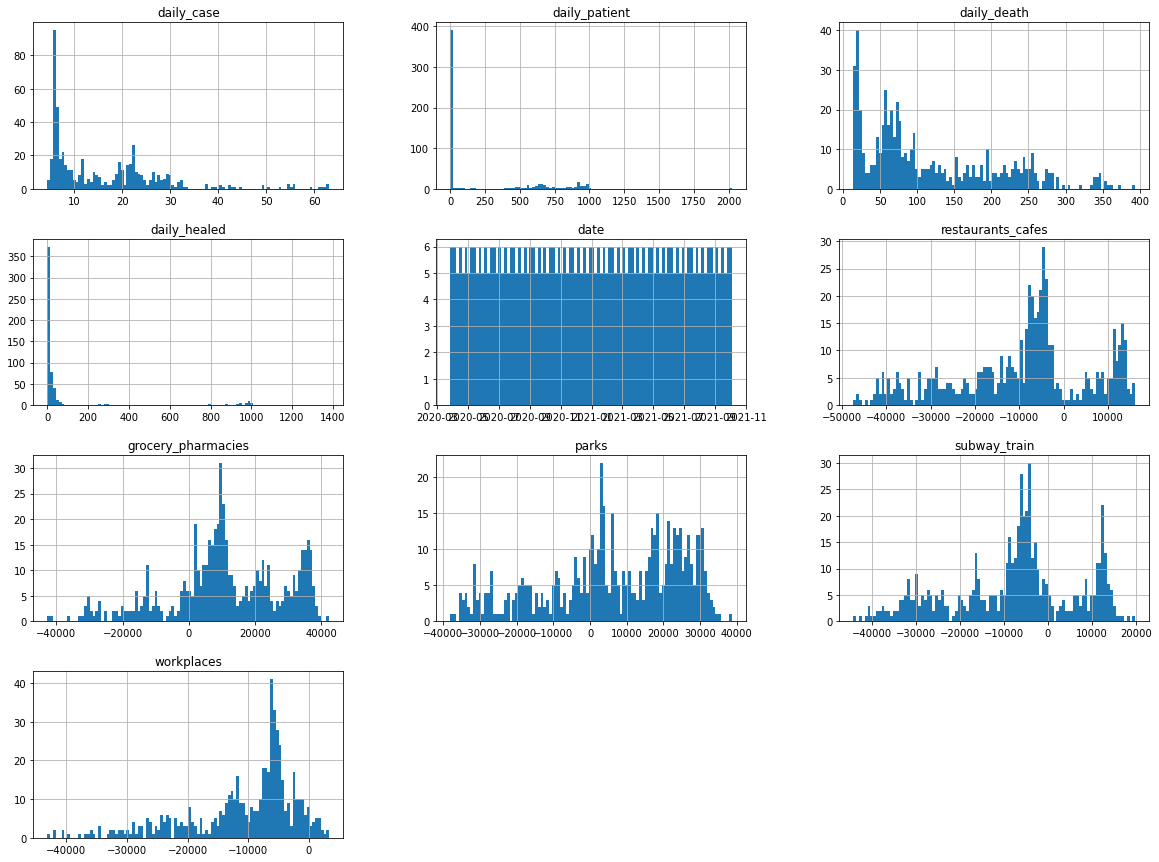

In [738]:
mobility_death_data.hist(bins=100, figsize=(20,15))
plt.show()

Bir biri ile yüksek derecede ilişkili olan değişkenler var mı 

In [739]:
corr_matrix = mobility_death_data.corr()
corr_matrix["daily_death"].sort_values(ascending=False)

daily_death           1.000000
daily_case            0.685781
grocery_pharmacies    0.126518
subway_train         -0.056808
restaurants_cafes    -0.107025
workplaces           -0.178928
parks                -0.205949
daily_healed         -0.216914
daily_patient        -0.233837
Name: daily_death, dtype: float64

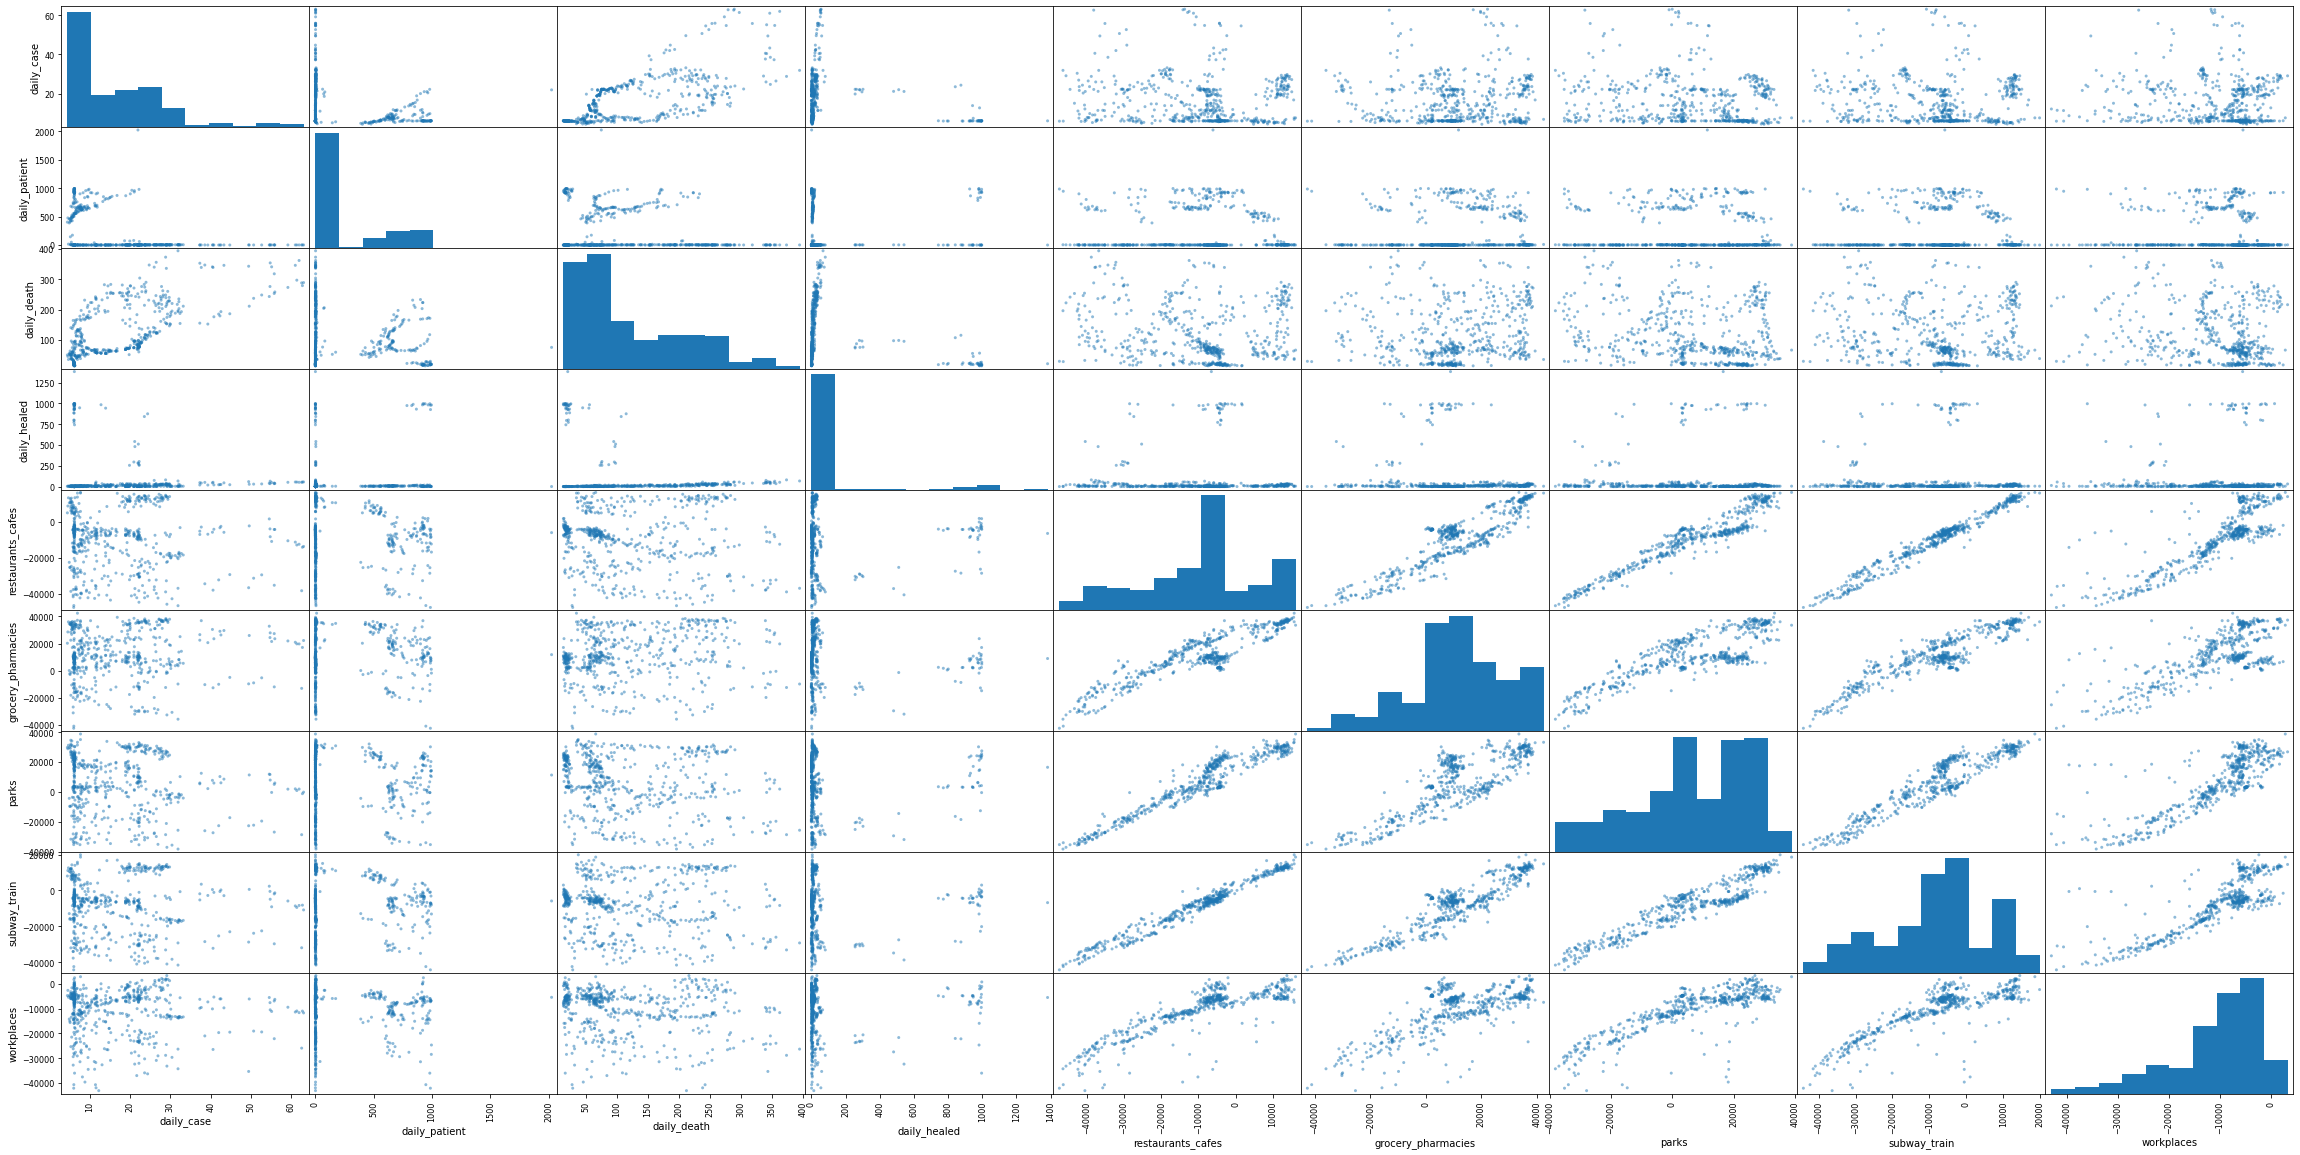

In [743]:

from pandas.plotting import scatter_matrix

scatter_matrix(mobility_death_data, figsize=(40, 20));


In [754]:
(mobility_death_data.daily_patient>700).sum()

78